# Building a model

In this notebook I will test various machine learning models to find one that gives the best results in predicting the churn.

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import srs

from sklearn import metrics

In [2]:
import seaborn as sns

sns.set()

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load data

In [4]:
dataset = pd.read_csv('../data/transformed.csv', index_col='customerID')

Description of the features:
* Gender: The customer’s gender: Male, Female
* Senior Citizen: Indicates if the customer is 65 or older: Yes, No
* Partner: Indicates if the customer is a partner: Yes, No
* Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
* Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
* Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
* Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
* Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No
* Device Protection Plan: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No
* Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No
* Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service
* Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service
* Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year
* Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
* Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
* Tenure Buckets: Indicates the range in which the customer's tenure value is, it is denoted in months: 0-20, 21-50, 50+
* Monthly Charges Buckets: Indicates a range in which the customer’s current total monthly charge is for all their services from the company: 0-40, 41-60, 60+
* Multiple Lines Buckets: Indicates if the customer subscribes to multiple telephone lines with the company: Yes; either has one line or not at all: Other
* Num Internet Services: Indicates the total number of additional internet services the customer has: 0 - 6
* Churn: Indicates if the customer have churned: Yes, No

In [5]:
dataset.head()

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TenureBuckets,MonthlyChargesBuckets,MultipleLinesBuckets,NumInternetlServices,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,No,Yes,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0-20,0-40,Other,1,No
5575-GNVDE,Male,No,No,No,Yes,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,21-50,41-60,Other,2,No
3668-QPYBK,Male,No,No,No,Yes,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,0-20,41-60,Other,2,Yes
7795-CFOCW,Male,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),21-50,41-60,Other,3,No
9237-HQITU,Female,No,No,No,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0-20,60+,Other,0,Yes


In [6]:
dataset.shape

(7043, 20)

In [7]:
data = dataset.sample(frac=0.9, random_state=45)
data_validation = dataset.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_validation.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Final Validation ' + str(data_validation.shape))

Data for Modeling: (6339, 20)
Unseen Data For Final Validation (704, 20)


### Building a model

To quickly iterate through various models i will use the [PyCaret](https://pycaret.org) library. It is an open-source, low-code machine learning library in Python that automates machine learning workflows.

The kind of a model that suits our case is a binary classification model.

In [8]:
from pycaret.classification import *

Initialize the training environment and create the transformation pipeline.

In [9]:
setup(
    data, 
    target='Churn',
    n_jobs=5,
    fold=5,
    train_size=0.8,
    silent=True,
    numeric_features=['NumInternetlServices'],
    normalize=True,
    fix_imbalance=True,
);

,Description,Value
0,session_id,7106
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(6339, 20)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,18
8,Ordinal Features,False
9,High Cardinality Features,False


Compare various models.

In [43]:
compare_models(include=['lr', 'svm', 'ridge', 'knn', 'dt'], sort='f1');

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7503,0.8421,0.7873,0.5220,0.6275,0.4513,0.4731,0.0500
svm,SVM - Linear Kernel,0.7606,0.0000,0.7518,0.5384,0.6265,0.4577,0.4725,0.0360
ridge,Ridge Classifier,0.7440,0.0000,0.7991,0.5140,0.6253,0.4447,0.4699,0.0180
knn,K Neighbors Classifier,0.7030,0.7536,0.7053,0.4634,0.5589,0.3494,0.3674,0.0860
dt,Decision Tree Classifier,0.7235,0.6720,0.4904,0.4826,0.4862,0.2972,0.2973,0.0200


### Tune the models

**Logisitc regression**

In [12]:
lr = create_model('lr');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7517,0.8496,0.7565,0.5243,0.6193,0.4440,0.4604
1,0.7623,0.8369,0.8111,0.5355,0.6451,0.4774,0.5007
2,0.7594,0.8577,0.7860,0.5338,0.6358,0.4658,0.4852
3,0.7288,0.8377,0.8081,0.4955,0.6143,0.4232,0.4533
4,0.7495,0.8289,0.7749,0.5211,0.6231,0.4461,0.4658
Mean,0.7503,0.8421,0.7873,0.5220,0.6275,0.4513,0.4731
SD,0.0118,0.0102,0.0205,0.0144,0.0113,0.0188,0.0174


In [13]:
custom_grid = {
    'fit_intercept': [True],
    'solver': ['saga'],
    'penalty': ['elasticnet'],
    'C': np.logspace(0.0001, 4, num=50) / 100,
    'class_weight': ['balanced'],
    'dual': [False],
    'max_iter': [1000],
    'l1_ratio': [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
}

In [14]:
%time tuned_lr = tune_model(lr, n_iter=1000, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7596,0.8487,0.7601,0.5351,0.6280,0.4583,0.4737
1,0.7623,0.8370,0.8333,0.5344,0.6512,0.4837,0.5112
2,0.7663,0.8598,0.8007,0.5425,0.6468,0.4816,0.5020
3,0.7249,0.8362,0.7970,0.4909,0.6076,0.4136,0.4425
4,0.7485,0.8301,0.7860,0.5195,0.6256,0.4479,0.4696
Mean,0.7523,0.8424,0.7954,0.5245,0.6318,0.4570,0.4798
SD,0.0149,0.0106,0.0237,0.0184,0.0158,0.0256,0.0245


CPU times: user 8.94 s, sys: 1.18 s, total: 10.1 s
Wall time: 7min 31s


In [15]:
tuned_lr

LogisticRegression(C=0.03728329487353944, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.9,
                   max_iter=1000, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=7106, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [16]:
srs.evaluate_model(tuned_lr, data=data_validation)

+---------------+------------+----------+-------------+------+
|               |   Accuracy |   Recall |   Precision |   F1 |
+===============+============+==========+=============+======+
| Model Summary |      0.743 |    0.731 |       0.509 |  0.6 |
+---------------+------------+----------+-------------+------+


**Ridge classifier**

In [17]:
ridge = create_model('ridge');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7488,0.0000,0.7675,0.5200,0.6200,0.4425,0.4612
1,0.7564,0.0000,0.8259,0.5272,0.6436,0.4719,0.4994
2,0.7544,0.0000,0.8007,0.5267,0.6354,0.4619,0.4850
3,0.7140,0.0000,0.8044,0.4791,0.6006,0.3993,0.4319
4,0.7465,0.0000,0.7970,0.5167,0.6270,0.4480,0.4721
Mean,0.7440,0.0000,0.7991,0.5140,0.6253,0.4447,0.4699
SD,0.0154,0.0000,0.0187,0.0179,0.0147,0.0249,0.0229


In [18]:
custom_grid = {
    'fit_intercept': [True],
    'max_iter': [1000],
    'normalize': [True, False],
    'class_weight': ['balanced'],
    'solver': ['auto'],
    'alpha': np.logspace(0.0001, 4, num=100) / 1000,
}

In [19]:
%time tuned_ridge = tune_model(ridge, n_iter=1000, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7517,0.0000,0.7712,0.5238,0.6239,0.4485,0.4672
1,0.7535,0.0000,0.8185,0.5237,0.6387,0.4650,0.4917
2,0.7623,0.0000,0.8118,0.5366,0.6461,0.4782,0.5014
3,0.7189,0.0000,0.8007,0.4844,0.6036,0.4057,0.4365
4,0.7436,0.0000,0.8044,0.5129,0.6264,0.4454,0.4716
Mean,0.7460,0.0000,0.8013,0.5163,0.6278,0.4486,0.4737
SD,0.0148,0.0000,0.0163,0.0176,0.0145,0.0245,0.0225


CPU times: user 2 s, sys: 361 ms, total: 2.36 s
Wall time: 12.5 s


In [20]:
tuned_ridge

RidgeClassifier(alpha=0.26563287220127, class_weight='balanced', copy_X=True,
                fit_intercept=True, max_iter=1000, normalize=True,
                random_state=7106, solver='auto', tol=0.001)

In [21]:
srs.evaluate_model(tuned_ridge, data=data_validation)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.746 |    0.742 |       0.513 | 0.607 |
+---------------+------------+----------+-------------+-------+


**SVM - with linear kernel**

In [22]:
svm = create_model('svm');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7645,0.0000,0.7528,0.5426,0.6306,0.4644,0.4778
1,0.7722,0.0000,0.7556,0.5528,0.6385,0.4780,0.4904
2,0.7761,0.0000,0.7970,0.5567,0.6555,0.4974,0.5149
3,0.7258,0.0000,0.7823,0.4919,0.6040,0.4105,0.4364
4,0.7643,0.0000,0.6716,0.5482,0.6036,0.4384,0.4429
Mean,0.7606,0.0000,0.7518,0.5384,0.6265,0.4577,0.4725
SD,0.0180,0.0000,0.0434,0.0238,0.0202,0.0304,0.0294


In [23]:
custom_grid = {
    'loss': ['hinge'], # This value is required for the SVM
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(0.0001, 4, num=50) / 100000,
    'l1_ratio': [0.05, 0.1, 0.25, 0.5, 0.75, 0.9],
    'fit_intercept': [True],
    'max_iter': [1000],
    'learning_rate': ['optimal'],
    'class_weight': ['balanced'],
}

In [ ]:
%time tuned_svm = tune_model(svm, n_iter=1000, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7685,0.0000,0.7712,0.5471,0.6401,0.4766,0.4919
1,0.7475,0.0000,0.8074,0.5166,0.6301,0.4521,0.4781
2,0.7890,0.0000,0.7749,0.5785,0.6625,0.5136,0.5252
3,0.7485,0.0000,0.7749,0.5198,0.6222,0.4445,0.4644
4,0.7327,0.0000,0.7749,0.5000,0.6078,0.4191,0.4422
Mean,0.7572,0.0000,0.7807,0.5324,0.6325,0.4612,0.4804
SD,0.0195,0.0000,0.0134,0.0276,0.0183,0.0320,0.0278


CPU times: user 14.4 s, sys: 2.03 s, total: 16.4 s
Wall time: 1min 39s


In [ ]:
tuned_svm

SGDClassifier(alpha=7.907455101892067e-05, average=False,
              class_weight='balanced', early_stopping=False, epsilon=0.1,
              eta0=0.001, fit_intercept=True, l1_ratio=0.05,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=5, penalty='elasticnet', power_t=0.5,
              random_state=7106, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
srs.evaluate_model(tuned_svm, data=data_validation)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.709 |    0.753 |       0.468 | 0.577 |
+---------------+------------+----------+-------------+-------+


**KNN**

In [ ]:
knn = create_model('knn');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7084,0.7551,0.6679,0.4677,0.5502,0.3442,0.3561
1,0.6893,0.7475,0.7333,0.4490,0.5570,0.3384,0.3626
2,0.7130,0.7698,0.6974,0.4749,0.5650,0.3622,0.3771
3,0.7022,0.7576,0.7528,0.4647,0.5746,0.3647,0.3898
4,0.7022,0.7383,0.6753,0.4610,0.5479,0.3374,0.3511
Mean,0.7030,0.7536,0.7053,0.4634,0.5589,0.3494,0.3674
SD,0.0080,0.0105,0.0329,0.0086,0.0099,0.0117,0.0142


In [ ]:
custom_grid = {
    'n_neighbors': np.arange(1, 21, 1),
    'weights': ['uniform', 'distance'],
    'leaf_size': [20, 30, 40],
    'p': [0, 1, 2]
}

In [ ]:
%time tuned_knn = tune_model(knn, n_iter=1000, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7458,0.8178,0.7306,0.5170,0.6055,0.4260,0.4399
1,0.7337,0.8012,0.7630,0.5000,0.6041,0.4163,0.4375
2,0.7594,0.8356,0.7934,0.5335,0.6380,0.4679,0.4886
3,0.7249,0.7960,0.7749,0.4907,0.6009,0.4067,0.4314
4,0.7337,0.8003,0.7417,0.5012,0.5982,0.4100,0.4277
Mean,0.7395,0.8102,0.7607,0.5085,0.6093,0.4254,0.4450
SD,0.0120,0.0147,0.0225,0.0151,0.0145,0.0223,0.0222


CPU times: user 5.21 s, sys: 571 ms, total: 5.78 s
Wall time: 1min 13s


In [ ]:
tuned_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=5, n_neighbors=18, p=1,
                     weights='uniform')

In [ ]:
srs.evaluate_model(tuned_knn, data=data_validation)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.733 |    0.694 |       0.496 | 0.578 |
+---------------+------------+----------+-------------+-------+


**Decision tree**

In [ ]:
dt = create_model('dt');

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7517,0.6979,0.5424,0.5345,0.5385,0.3687,0.3687
1,0.7032,0.6517,0.4889,0.4475,0.4673,0.2621,0.2626
2,0.7298,0.6868,0.4945,0.4945,0.4945,0.3101,0.3101
3,0.7288,0.6673,0.5055,0.4928,0.4991,0.3132,0.3132
4,0.7041,0.6566,0.4207,0.4436,0.4318,0.2320,0.2322
Mean,0.7235,0.6720,0.4904,0.4826,0.4862,0.2972,0.2973
SD,0.0182,0.0177,0.0395,0.0338,0.0354,0.0469,0.0468


In [ ]:
custom_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': np.arange(2, 11, 1),
    'max_features': ['log2'],
    'class_weight': ['balanced'],
    'ccp_alpha': np.logspace(0.0001, 4, num=50)[:25] / 10000
}

In [ ]:
%time tuned_dt = tune_model(dt, n_iter=1000, optimize='f1', custom_grid=custom_grid)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7783,0.8212,0.6753,0.5719,0.6193,0.4644,0.4676
1,0.7722,0.8118,0.6963,0.5579,0.6194,0.4597,0.4654
2,0.7860,0.8443,0.7454,0.5771,0.6506,0.4999,0.5084
3,0.7643,0.8162,0.7232,0.5444,0.6212,0.4551,0.4647
4,0.7495,0.8007,0.7085,0.5232,0.6019,0.4251,0.4355
Mean,0.7701,0.8188,0.7097,0.5549,0.6225,0.4608,0.4683
SD,0.0125,0.0144,0.0238,0.0195,0.0157,0.0239,0.0233


CPU times: user 4 s, sys: 415 ms, total: 4.42 s
Wall time: 25.5 s


In [ ]:
tuned_dt

DecisionTreeClassifier(ccp_alpha=0.002023903474267161, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=7106,
                       splitter='best')

In [ ]:
srs.evaluate_model(tuned_dt, data=data_validation)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.722 |    0.613 |       0.479 | 0.538 |
+---------------+------------+----------+-------------+-------+


### Finalize a model

In [ ]:
final_lr = finalize_model(lr)

In [46]:
final_lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7106, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
srs.evaluate_model(final_lr, data=data_validation)

+---------------+------------+----------+-------------+-------+
|               |   Accuracy |   Recall |   Precision |    F1 |
+===============+============+==========+=============+=======+
| Model Summary |      0.741 |     0.71 |       0.508 | 0.592 |
+---------------+------------+----------+-------------+-------+


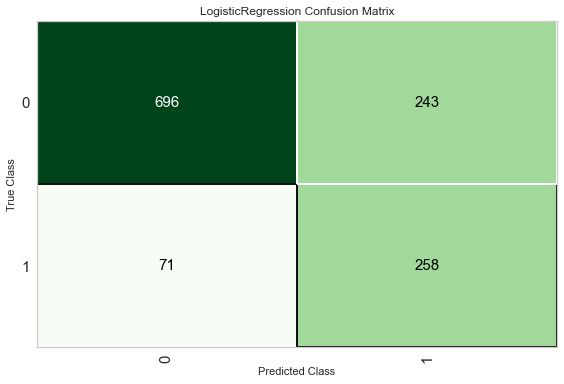

In [ ]:
plot_model(final_lr, plot = 'confusion_matrix', save=True)
plot_model(final_lr, plot = 'confusion_matrix', save=False)

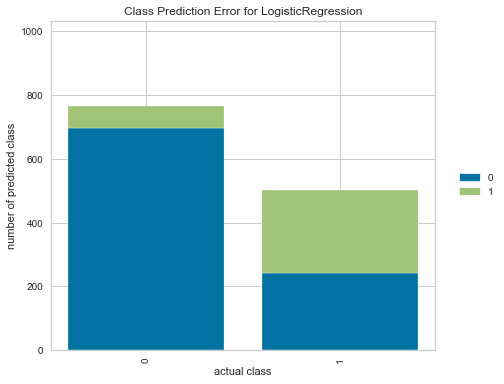

In [ ]:
plot_model(final_lr, plot = 'error', save=True)
plot_model(final_lr, plot = 'error', save=False)

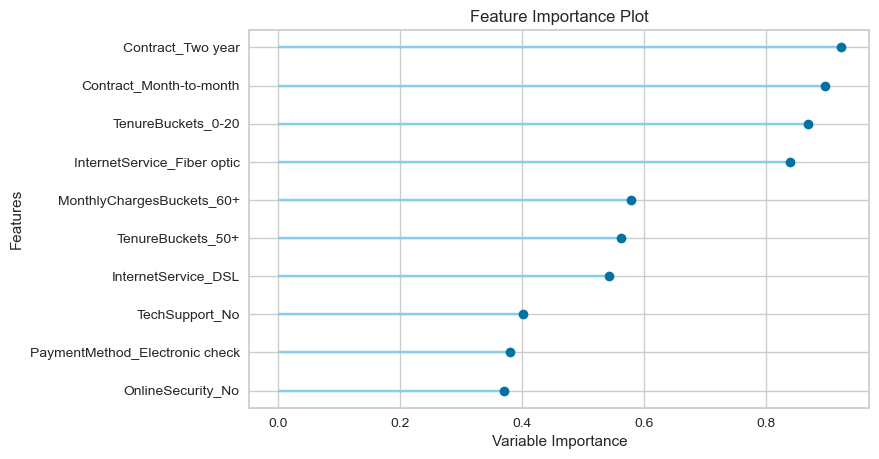

In [ ]:
plot_model(final_lr, plot = 'feature', save=True)
plot_model(final_lr, plot = 'feature', save=False)

Save the model.

In [ ]:
save_model(final_lr, 'lr_pipeline_31102021', model_only=False)

In [ ]:
# final_lr = load_model('../model/lr_pipeline_31102021')